In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
import cv2
import random
import sys
sys.path.append("src")
import sindy_utils as sindy

# autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__() 
        self.encode = nn.Sequential(
            # encoder: N, 3, 404, 720
            nn.Conv2d(3, 16, 2), # N, 16, 403, 719
            nn.ReLU(),
            nn.Conv2d(16, 32, 2), # N, 32, 402, 718
            nn.ReLU(),
            nn.MaxPool2d((2,3), stride=(2,3)), # N, 32, 201, 239              -- pool --
            nn.Conv2d(32, 64, 4), # N, 64, 198, 236
            nn.ReLU(),
            nn.Conv2d(64, 96, 4), # N, 96, 195, 233
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2), # N, 96, 97, 116                       -- pool --
            nn.Conv2d(96, 128, 5), # N, 128, 93, 112
            nn.ReLU(),
            nn.Conv2d(128, 150, 5, stride=2, padding=1), # N, 150, 46, 55
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2), # N, 150, 23, 27                        -- pool --
            nn.Conv2d(150, 200, 9, stride=2), # N, 200, 8, 10
            nn.ReLU()
        )
        
        self.fc1 = nn.Linear(200*8*10,params['z_dim'])
        # Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
        # Input [-1, +1] -> use nn.Tanh    
        
        # note: encoder and decoder are not symmetric
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(200, 150, 4), # N, 150, 11, 13
            nn.ReLU(),
            nn.ConvTranspose2d(150, 128, 5, stride=(2,3), padding=(2,2), output_padding=(0,2)), # N, 128, 21, 39
            nn.ReLU(),
            nn.ConvTranspose2d(128, 96, 4, stride=2, padding=(1,0)), # N, 96, 42, 80
            nn.ReLU(),
            nn.ConvTranspose2d(96, 64, 8), # N, 64, 49, 87
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 8, stride=2, padding=(2,1), output_padding=(0,1)), # N, 32, 100, 179
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 5, stride=2, padding=1), # N, 16, 201, 359
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 5, stride=2, padding=1, output_padding=(1,1)), # N, 3, 404, 720
            nn.ReLU()
        )   
        
        self.fc2 = nn.Linear(params['z_dim'], 200*8*10)

    def forward(self, x, z, mode):
        '''
        x: input for encoder
        z: input for decoder
        mode: 
            'train' -> use encoded for decoder
            'test'  -> feed z in an get decoded
        
        '''
        if mode == 'train':
            encoded = self.encode(x)
            encoded = encoded.view(-1,200*8*10)
            encoded = self.fc1(encoded)

            decoded = self.fc2(encoded)
            decoded = decoded.view(-1,200,8,10)
            decoded = self.decode(decoded)
        else:
            encoded = torch.zeros(1)

            decoded = self.fc2(z)
            decoded = decoded.view(-1,200,8,10)
            decoded = self.decode(decoded)
        
        return encoded, decoded

    
def calculateSindy(z, Xi, poly_order, include_sine_param):
    z_new = z.detach().numpy()
    
    theta = torch.from_numpy(sindy.sindy_library(z_new, poly_order, include_sine=include_sine_param))
    
    dz_prediction = torch.matmul(theta, Xi).float()
    
    return dz_prediction

In [2]:
# loading model and Xi
path_folder = 'results/run1_lre-5_z5_poly4/'
autoencoders_list = []
Xi_list = []

for i in range(0,601, 100):
    to_load = path_folder+'Ae_'+str(i)+'epoch_bs16_lr1e-5_z5_sindth0-5_poly5.pt'
    autoencoder = torch.load(to_load)
    autoencoders_list.append(autoencoder)
    Xi_list.append(torch.load(path_folder+'Xi_'+str(i)+'epoch_bs16_lr1e-5_z5_sindth0-5_poly5.pt'))
    #print('autoencoder length', len(autoencoders_list))

# loading ae and sindy loss
aeLoss_list = torch.load(path_folder+'AeLoss_600epoch_bs16_lr1e-5_z5_sindth0-5_poly5.pt')
sindyLoss_list = torch.load(path_folder+'sindyLoss600epoch_bs16_lr1e-5_z5_sindth0-5_poly5.pt')
print(len(aeLoss_list))


# loading test data
batch_size = 16
file_names = []
path_test = '../../Videos/test/'
for f in listdir(path_test):
    if f != 'high_res':
        file_names.append(f)

random.shuffle(file_names)

# define transform to tensor and resize to 1080x1920, 720x404 (16:9)
# pictures are 16:9 --> 1080x1920, 900x1600, 720x1280, 576x1024, 540x960: 500k pixel, 360x640, 272x480
# normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])    # normalize around mean with sigma (std)
# transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((1080, 1920))])
transform = transforms.ToTensor()

# read data to list and transform to tensor
test_data_tmp = []
test_data = []
test_idxOfNewVideo = []
count = 0
for f in file_names:
    # if count == 10:
    #     break
    count += 1
    test_idxOfNewVideo.append(len(test_data))
    vidcap = cv2.VideoCapture(path_test + f)
    success,imgR = vidcap.read()
    print('Read test data:',f)
    while success:
        imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)
        imgR_tensor = transform(imgR)
        test_data_tmp.append(imgR_tensor)
        success,imgR = vidcap.read()
        # make a batch
        if len(test_data_tmp) >= batch_size:
            test_data.append(torch.stack(test_data_tmp))
            test_data_tmp = []
    
    print('test data: ', len(test_data), len(test_data[0]), len(test_data[0][0]), len(test_data[0][0][0]), len(test_data[0][0][0][0]))

print('index of new videos: ', test_idxOfNewVideo)
print('test data reading done!')

del test_data_tmp




# load a train image, for testing
train_debug = []
train_debug_tmp = []
vidcap = cv2.VideoCapture('../../Videos/train/Cu_2_Trim_low.mov')
success,imgR = vidcap.read()
print('Read test data:')
while success:
    imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)
    imgR_tensor = transform(imgR)
    train_debug_tmp.append(imgR_tensor)
    success,imgR = vidcap.read()
    # make a batch
    if len(train_debug_tmp) >= batch_size:
        train_debug.append(torch.stack(train_debug_tmp))
        train_debug_tmp = []
    
print('train debug: ', len(train_debug), len(train_debug[0]), len(train_debug[0][0]), len(train_debug[0][0][0]), len(train_debug[0][0][0][0]))

601
Read test data: St_Fabio1_low.mov
test data:  26 16 3 404 720
Read test data: Cb_2_low.mov
test data:  50 16 3 404 720
Read test data: Ac_timelapse_sunrise_low.mov
test data:  55 16 3 404 720
index of new videos:  [0, 26, 50]
test data reading done!
Read test data:
train debug:  38 16 3 404 720


C:\Users\timok\AppData\Local\Temp/ipykernel_18128/1063190477.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 432x288 with 0 Axes>

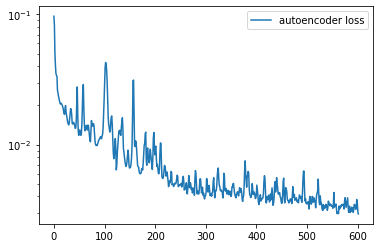

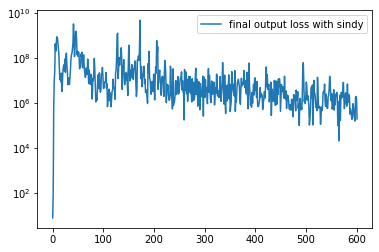

In [33]:
# plot loss (sindy loss was not calculated properly)
X = np.linspace(0,601,601)
plt.figure()
fig, ax = plt.subplots()
line_up, = ax.plot(X, aeLoss_list, label='autoencoder loss')
ax.legend(handles=[line_up])
ax.set_yscale('log')
fig, ax = plt.subplots()
line_down, = ax.plot(X, sindyLoss_list, label='final output loss with sindy')
ax.legend(handles=[line_down])
ax.set_yscale('log')

fig.savefig('figures/run1_lre-5_z5_poly4/lossPlot.pdf')
fig.show()



In [4]:
# choose which autoencoder to use
use_id = 6
autoencoder = autoencoders_list[use_id]
autoencoder = autoencoder.cpu()
#print(autoencoder)
Xi = Xi_list[use_id]
print(Xi)
poly_order = 4
include_sine_param = False
until = 5                      # choose the number of prediction stepts, 1 step are number of batch_size frames

# test model
def test(data):
    video_reconstruction = []
    # predict videos
    for vid_nbr in range(0, len(test_idxOfNewVideo)):
        print('video number', vid_nbr)
        # first step encode first batch
        img = data[test_idxOfNewVideo[vid_nbr]]
        encode_tensor, recon_tensor = autoencoder(img, 0, mode='train')
        # too big
        if vid_nbr == 2:
            break
        
        # predict the future using only sindy model, new video starts always at position vid_nbr * until
        for i in range(0, until):
            #print('pred', i)
            video_reconstruction.append(recon_tensor)
            dz_tensor = calculateSindy(encode_tensor, Xi, poly_order, include_sine_param)
            encode_tensor = dz_tensor
            _, recon_tensor = autoencoder(0, dz_tensor, mode='test')
            
    return video_reconstruction


# test for different models or epoch number, TODO
video_output = test(train_debug)
print('prediction done!')

#del test_data


AttributeError: 'Autoencoder' object has no attribute 'shape'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10


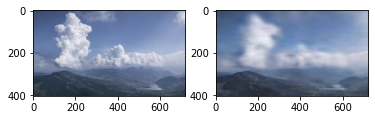

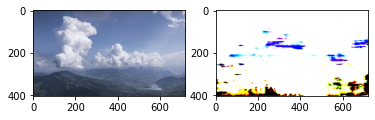

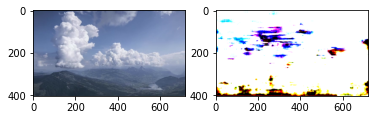

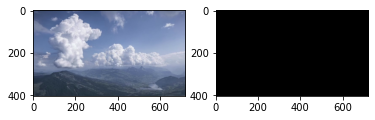

In [71]:
# first picture comparision
print(len(video_output))
#for i in range(0, len(video_output)):
plt.figure()
plt.subplot(1,2,1)
plt.imshow(train_debug[0][0].permute(1,2,0).detach().numpy())
plt.subplot(1,2,2)
plt.imshow(video_output[0][0].permute(1,2,0).detach().numpy())

plt.figure()
plt.subplot(1,2,1)
plt.imshow(train_debug[1][0].permute(1,2,0).detach().numpy())
plt.subplot(1,2,2)
plt.imshow(video_output[1][0].permute(1,2,0).detach().numpy())

plt.figure()
plt.subplot(1,2,1)
plt.imshow(train_debug[2][0].permute(1,2,0).detach().numpy())
plt.subplot(1,2,2)
plt.imshow(video_output[2][0].permute(1,2,0).detach().numpy())

plt.figure()
plt.subplot(1,2,1)
plt.imshow(train_debug[3][0].permute(1,2,0).detach().numpy())
plt.subplot(1,2,2)
plt.imshow(video_output[3][0].permute(1,2,0).detach().numpy())


In [55]:
# make videos
frame_width = len(video_output[0][0][0][0])
frame_height = len(video_output[0][0][0])
fps = 25.0

# write different videos
#forcc = cv2.VideoWriter_fourcc('M','J','P','G')
forcc = cv2.VideoWriter_fourcc('D','I','V','3')
#forcc = cv2.VideoWriter_fourcc('F','M','P','4')
out1 = cv2.VideoWriter('figures/run1_lre-5_z5_poly4/videoTest.avi', forcc, 1, (frame_width,frame_height))
#out2 = cv2.VideoWriter('video2.mov',cv2.VideoWriter_fourcc('M','J','P','G'), fps, (frame_width,frame_height))
#out3 = cv2.VideoWriter('video3.mov',cv2.VideoWriter_fourcc('M','J','P','G'), fps, (frame_width,frame_height))
    
print('output video', len(video_output), len(video_output[0]), len(video_output[0][0]), len(video_output[0][0][0]), len(video_output[0][0][0][0]))

for vid_nbr in range(0, len(test_idxOfNewVideo)):
    if vid_nbr == 1:
        break
    # undo batch structure
    videoProcessing = []
    count = -1
    for img in range(0, len(video_output)*len(video_output[0])):
        imgIn_batch = img % batch_size
        # new batch
        if imgIn_batch == 0:
            count += 1
        img_toAppend = video_output[count][imgIn_batch]
        videoProcessing.append(img_toAppend)
        
    #del video_output
    print('video currently procession', len(videoProcessing), len(videoProcessing[0]), len(videoProcessing[0][0]), len(videoProcessing[0][0][0]))
    
    for img in range(0,len(videoProcessing)):
        frame_local = np.transpose(videoProcessing[img].detach().numpy(), [1,2,0])
        frame_local = cv2.cvtColor(frame_local, cv2.COLOR_RGB2BGR)
        # print(frame_local) --> seems unstable, not a number and doesn't save it as a video
        out1.write(frame_local.shape)
        # show video
        cv2.imshow('Frame',frame_local)

        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q') and img >= 10:
            break

    # When everything done, release the video capture and video write objects
    out1.release()

    # Closes all the frames
    cv2.destroyAllWindows()

print('finished prediction video output!')

output video 10 16 3 404 720
video currently procession 160 3 404 720
finished prediction video output!
